In [381]:
%matplotlib notebook
import matplotlib.pyplot as plt

from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
import cv2
import cv2.cv as cv
import numpy as np
import picar
from math import *
picar.setup()
import numpy as np

bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 8
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(90)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=1.2/210
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [382]:
def controller(current_position_pose,waypoint,L,precision,v_min,v_max,k_rho=1,k_alpha=1*5,k_beta=-1*2):
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
#     if delta_x==0:
#         if delta_y==0:
#             return 0,0
#         if delta_y<0:
#             alpha=-pi/2-theta
#         else:
#             alpha=pi/2-theta
#     else:
#         alpha=atan(delta_y/abs(delta_x))-theta
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    v=k_rho*rho*direction
    if v==0:
        return 0,0
    if abs(v)<v_min:
        v=v_min*direction
    if abs(v)>v_max:
        v=v_max*direction
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def controller_cs(current_position_pose,waypoint,L,precision,v_min,k_rho=1.0,k_alpha=1*4.5,k_beta=-1*2.5):
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    k=v_min/rho
    ratio=k/k_rho
    k_alpha=k_alpha*ratio
    k_beta=k_beta*ratio
    v=v_min*direction
    if v==0:
        return 0,0
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
#     gamma=round(abs(gamma))
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def isclose(a, b, rel_tol=5e-01, abs_tol=0.1):
    x,y,_=a
    xg,yg,_=b
    deltad=sqrt((xg-x)**2+(yg-y)**2)
    return abs(deltad-0) <= max(rel_tol * max(abs(deltad), abs(0)), abs_tol)

In [383]:
# current_position_pose=(1.0002775916930104, 0.9900540656994266, 1.6155577259489429)

# waypoint=(2.0, 1.0, 0.0)
# v,gamma=controller(current_position_pose,waypoint,L)
# (x,y,theta)=current_position_pose
# (xg,yg,thetag)=waypoint
# delta_x=xg-x
# delta_y=yg-y
# rho=sqrt(delta_x**2+delta_y**2)
# alpha=atan2(delta_y,delta_x)-theta
# beta=-theta-alpha+thetag
# if -pi/2<alpha<=pi/2:
#     direction=1
# else:
#     direction=-1
#     alpha_prime=-pi-beta
#     beta_prime=-pi-alpha
    


# # # Control signal
# # v=k_rho*rho
# # if v==0:
# #     return 0,0
# # omega=k_alpha*alpha+k_beta*beta
# # gamma=atan(omega*L/v)
# print theta,thetag
# print delta_x,delta_y,atan2(delta_y,delta_x)
# print alpha,beta
# print delta_x,delta_y,atan2(-2,-1)


In [384]:
waypoints=[]
with open("waypoints.txt", "r") as filestream:
    for line in filestream:
        currentline = line.rstrip().split(",")
#         print tuple([float(i) for i in currentline])
        waypoints.append(tuple([float(i) for i in currentline]))

In [385]:
# waypoints


In [386]:
debug_mode=False

In [ ]:
# for manually assignment of initial position_pose
# initial_position_pose=(0.0,0.0,0.0)

initial_position_pose=waypoints[0]
fw.turn(initial_angle_fw)

current_position_pose=initial_position_pose
current_angle_fw=initial_angle_fw
archived_x_y_theta=[]

deltat=0.05
for waypoint in waypoints:
    print 'heading to ' +str(waypoint)
    reached=False
    while not reached:
        x,y,theta=current_position_pose
#         v,gamma=controller(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED,MAX_SPEED)
        v,gamma=controller_cs(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED)
        if v<0:
            direction=-1
        else:
            direction=1
        v=abs(v)
#         count as no turnning
#         if abs(gamma)<3*MIN_RADIAN:
#             gamma=0
        if not debug_mode:
            fw.turn(current_angle_fw-gamma*180/pi)
#         current_angle_fw=current_angle_fw-gamma*180/pi
        motor_speed=int(round(abs(v)/true_speed_unit))
        if not debug_mode:
            bw.speed = motor_speed
        true_speed=motor_speed*true_speed_unit
        if direction==1:
            bw.backward()
        elif direction==-1:
            bw.forward()
        if not debug_mode:
            sleep(deltat)
        bw.stop()
#         if gamma==0:
#             delta_position_pose=(true_speed*cos(theta)*deltat,true_speed*sin(theta)*deltat,0)
#         else:
#             Rb=L/tan(gamma)
#             K=true_speed/Rb
#             delta_position_pose=(Rb*sin(K*deltat),Rb*(1-cos(K*deltat)),K*deltat)
        delta_position_pose=(true_speed*cos(theta)*deltat*direction,true_speed*sin(theta)*deltat*direction,true_speed/L*tan(gamma)*deltat*direction)
        print delta_position_pose
        current_position_pose=tuple(map(sum, zip(current_position_pose, delta_position_pose)))
        archived_x_y_theta.append(current_position_pose)
        print current_position_pose
        if(isclose(current_position_pose,waypoint,abs_tol=deltat*MIN_SPEED) or v==0):
            reached=True
            print str(waypoint)+' reached'
            fw.turn(current_angle_fw)
    if not debug_mode:
        raw_input("Press Enter to continue...")

        

heading to (0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0) reached
Press Enter to continue...s
heading to (1.0, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.020000000000000004, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.04000000000000001, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.06000000000000001, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.08000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.10000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.12000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.14, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.16000000000000003, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.18000000000000005, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.20000000000000007, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.22000000000000008, 0.0, 0.0)
0.4 0.0 0.0
(0.02000000000000

(-0.006832327916976061, 0.018796789492754064, 0.012987982871337251)
(1.1384054950134412, 0.5014470926689141, 1.9324205345517729)
0.4 0.208924810716 0.0729937677375
(-0.007075877176576631, 0.018706468458316815, 0.010446240535805468)
(1.1313296178368646, 0.5201535611272309, 1.9428667750875783)
0.4 0.158968979006 0.0555818347652
(-0.007270899821368761, 0.01863153283515932, 0.007948448950291277)
(1.1240587180154957, 0.5387850939623902, 1.9508152240378696)
0.4 0.109921091383 0.038453417522
(-0.007418760370960231, 0.018573152520729216, 0.00549605456912627)
(1.1166399576445354, 0.5573582464831194, 1.9563112786069958)
0.4 0.061811680306 0.0216307138933
(-0.007520726869284982, 0.018532098298833163, 0.003090584015297671)
(1.1091192307752504, 0.5758903447819526, 1.9594018626222935)
0.4 0.01467171723 0.00513505589495
(-0.007577965867007525, 0.018508766391050188, 0.0007335858615013235)
(1.101541264908243, 0.5943991111730027, 1.960135448483795)
0.4 -0.0314684316681 -0.0110135057594
(-0.0075915415960

(0.01927786908862511, -0.005325764114362613, -0.025339155391931413)
(1.414483876654414, 1.1734560694550678, -0.29487929217694153)
0.4 -0.451373800794 -0.156685875139
(0.01913674459849658, -0.005812487090042623, -0.022568690039709932)
(1.4336206212529108, 1.167643582365025, -0.3174479822166515)
0.4 -0.396778378258 -0.137989878563
(0.019000702111634737, -0.00624286146449842, -0.01983891891292195)
(1.4526213233645455, 1.1614007209005266, -0.33728690112957344)
0.4 -0.343001288163 -0.119478660399
(0.01887311956218936, -0.006618561625557746, -0.017150064408129353)
(1.471494442926735, 1.1547821592749687, -0.35443696553770276)
0.4 -0.290055601626 -0.101172841469
(0.018756840910855513, -0.006941247657651837, -0.01450278008129604)
(1.4902512838375905, 1.147840911617317, -0.3689397456189988)
0.4 -0.237961243477 -0.0830946570267
(0.01865420451694599, -0.007212534494888179, -0.0118980621738576)
(1.5089054883545365, 1.1406283771224288, -0.38083780779285636)
0.4 -0.186743343624 -0.0652673362682
(0.01

(-0.019383929224102047, 0.004925777891359165, 0.027633661078596262)
(1.8883206240200676, 1.2468464268704138, 2.9203769874436505)
0.4 0.393181719281 0.1367546546
(-0.01951262867837982, 0.004388316540504958, 0.019659085964037898)
(1.8688079953416878, 1.2512347434109188, 2.9400360734076885)
0.4 0.250605738737 0.0874881067735
(-0.01959512291802168, 0.00400389283418295, 0.012530286936828073)
(1.8492128724236663, 1.2552386362451018, 2.9525663603445165)
0.4 -1.57796445756 0.504597798451
(-0.01964375325496982, 0.0037580524288336873, 0.07889822287788645)
(1.8295691191686965, 1.2589966886739354, 3.031464583222403)
0.4 -1.37633809331 0.448915602946
(-0.019878840609159447, 0.0021981119251833813, 0.06881690466574056)
(1.809690278559537, 1.261194800599119, 3.1002814878881435)
0.4 -1.18591949227 0.393431430008
(-0.01998293630285058, 0.0008259883269250691, 0.05929597461329216)
(1.7897073422566865, 1.262020788926044, 3.1595774625014355)
0.4 -1.0087860442 0.339411712127
(-0.01999676555366824, -0.0003596

(-0.017841942296096893, 0.00903687418871972, -0.02665059106434712)
(0.871991863449027, 1.2677230182244354, 2.646111088759396)
0.4 0.536233049057 -0.185523344963
(-0.017594796985480735, 0.009509107163120945, -0.02681165245284522)
(0.8543970664635463, 1.2772321253875565, 2.619299436306551)
0.4 0.539394221625 -0.186591894083
(-0.01733354889388103, 0.00997737855067331, -0.02696971108124669)
(0.8370635175696652, 1.2872095039382299, 2.5923297252253046)
0.4 0.542504113302 -0.187642688581
(-0.01705819096755728, 0.010441174307248552, -0.02712520566509055)
(0.820005326602108, 1.2976506782454784, 2.565204519560214)
0.4 0.545570697317 -0.188678439528
(-0.01676873157114475, 0.010899983554799215, -0.0272785348658683)
(0.8032365950309632, 1.3085506618002776, 2.5379259846943456)
0.4 0.548601231839 -0.189701612284
(-0.016465194289292554, 0.011353298067779597, -0.027430061591929313)
(0.7867714007416706, 1.319903959868057, 2.5104959231024164)
0.4 0.551602335864 -0.190714452655
(-0.016147617789385952, 0.0

(0.008747735863370116, 0.017985469614794837, -0.025702305143113502)
(0.5754546233000181, 2.171310473863468, 1.0924033177511683)
0.4 -0.509778128505 -0.176564375782
(0.009207063741641318, 0.017754717042446886, -0.02548890642524392)
(0.5846616870416593, 2.189065190905915, 1.0669144113259244)
0.4 -0.505828064461 -0.175224187863
(0.009656572381581444, 0.017514297297901465, -0.025291403223045475)
(0.5943182594232408, 2.2065794882038166, 1.0416230081028788)
0.4 -0.502178931028 -0.173985534957
(0.010096398041345286, 0.017264493812177616, -0.02510894655137895)
(0.6044146574645861, 2.2238439820159943, 1.0165140615514998)
0.4 -0.49881497222 -0.172843202983
(0.01052666322888845, 0.017005568536969527, -0.0249407486109821)
(0.6149413206934745, 2.240849550552964, 0.9915733129405178)
0.4 -0.495721555984 -0.171792339391
(0.01094747703087779, 0.016737764087786735, -0.02478607779919914)
(0.6258887977243524, 2.257587314640751, 0.9667872351413186)
0.4 -0.492885084102 -0.170828425341
(0.011358935459305025,

(0.019762538124456164, -0.0030727978910785286, -0.026204033935460603)
(1.4414438757844907, 2.614540093183055, -0.18045489137667914)
0.4 -0.527209014842 -0.182470662076
(0.01967524303980618, -0.0035895419379857563, -0.026360450742102217)
(1.461119118824297, 2.610950551245069, -0.20681534211878136)
0.4 -0.530434092529 -0.18356205102
(0.019573796549039114, -0.004106883082926106, -0.026521704626466816)
(1.480692915373336, 2.606843668162143, -0.2333370467452482)
0.4 -0.533757105136 -0.184686119371
(0.019458004069058697, -0.0046245083683020055, -0.02668785525681592)
(1.5001509194423945, 2.602219159793841, -0.26002490200206413)
0.4 -0.537179363994 -0.185843266266
(0.019327671520288928, -0.005142092337153476, -0.026858968199690105)
(1.5194785909626836, 2.5970770674566874, -0.2868838702017542)
0.4 -0.540702299064 -0.187033928449
(0.019182605718459277, -0.005659296586161, -0.02703511495320415)
(1.5386611966811428, 2.5914177708705264, -0.31391898515495836)
0.4 -0.544327459794 -0.188258580359
(0.0

(-0.01244255375469365, -0.015658315875647644, -0.07349016391484094)
(1.9430892004062457, 1.8593665831489607, -2.3157439148480217)
0.4 -1.39428312215 -0.454000873184
(-0.013558665642728921, -0.014702468703883795, -0.06971415610741959)
(1.9295305347635168, 1.844664114445077, -2.3854580709554414)
0.4 -1.31956978985 -0.432664101673
(-0.01454987115965392, -0.013722290232955693, -0.06597848949226107)
(1.9149806636038629, 1.8309418242121214, -2.4514365604477026)
0.4 -1.24551148004 -0.41109108653
(-0.01542293293025897, -0.012733151213612973, -0.06227557400204961)
(1.899557730673604, 1.8182086729985083, -2.513712134449752)
0.4 -1.1720050182 -0.389269940652
(-0.016185487470118377, -0.01174861674218038, -0.05860025090978738)
(1.8833722432034856, 1.806460056256328, -2.5723123853595395)
0.4 -1.09899151275 -0.36720140043
(-0.016845782948000466, -0.010780519322781111, -0.05494957563762268)
(1.8665264602554852, 1.795679536933547, -2.627261960997162)
0.4 -1.02645205213 -0.344898748918
(-0.0174124436912

(-0.014349732717747891, -0.013931445399856966, 0.041117832638831175)
(1.025137381213169, 1.5258393216100794, -2.32986588661576)
0.4 0.839181700786 0.285679518999
(-0.013764934609080735, -0.014509533941782261, 0.041959085039309604)
(1.0113724466040883, 1.5113297876682972, -2.2879068015764505)
0.4 0.855866395554 0.291046871108
(-0.013144191213279055, -0.0150741579316643, 0.04279331977767653)
(0.9982282553908093, 1.496255629736633, -2.245113481798774)
0.4 0.872470469611 0.296371209084
(-0.012487281384928045, -0.015622669541843019, 0.04362352348055717)
(0.9857409740058812, 1.4806329601947898, -2.201489958318217)
0.4 0.889052552873 0.301671272725
(-0.011794101790455258, -0.016152373291760568, 0.044452627643657906)
(0.973946872215426, 1.4644805869030293, -2.1570373306745587)
0.4 0.90567043782 0.306965298666
(-0.011064671935585378, -0.0166605232498223, 0.04528352189102426)
(0.9628822002798406, 1.447820063653207, -2.1117538087835346)
0.4 0.922381365876 0.312271107859
(-0.010299139929377503, -0

(-0.0199718746623406, 0.0010602935780988263, -0.04352332797345304)
(0.7683422279543389, 0.7387779411606581, -3.238155525384518)
0.4 -0.772664975513 -0.264115128604
(-0.019906828548904715, 0.0019282575358370302, -0.03863324877565867)
(0.7484353994054342, 0.7407061986964951, -3.2767887741601767)
0.4 -0.677739978528 -0.232904313307
(-0.019817498324389955, 0.002695692891039596, -0.033886998926392214)
(0.7286179010810443, 0.7434018915875347, -3.310675773086569)
0.4 -0.586023217506 -0.202302360062
(-0.019714789452190046, 0.003365572292466195, -0.029301160875310747)
(0.7089031116288542, 0.7467674638800008, -3.3399769339618794)
0.4 -0.497803768729 -0.172499729623
(-0.019607725847654543, 0.003941711187190159, -0.02489018843643263)
(0.6892953857811996, 0.7507091750671909, -3.364867122398312)
0.4 -0.413320458439 -0.143665523108
(-0.01950355265321867, 0.004428479863692167, -0.020666022921956545)
(0.669791833127981, 0.7551376549308831, -3.385533145320269)
0.4 -0.332757417315 -0.11594275842
(-0.0194

(-0.014775954919053534, -0.013478544291951479, 0.038895336708223614)
(-0.18038843826562578, 0.6965353591507651, -2.363185647282473)
0.4 0.785332185666 0.268241874275
(-0.014240659104004972, -0.014042920931327654, 0.03926660928331191)
(-0.19462909736963074, 0.6824924382194375, -2.323919037999161)
0.4 0.79281875456 0.270676476938
(-0.013678405718017653, -0.014591134877496748, 0.0396409377279823)
(-0.2083075030876484, 0.6679013033419408, -2.284278100271179)
0.4 0.800387126021 0.273134342311
(-0.013089405178961531, -0.015121754926627238, 0.04001935630103226)
(-0.22139690826660993, 0.6527795484153135, -2.2442587439701467)
0.4 0.808057273308 0.275621811298
(-0.012473923538453939, -0.01563333718554055, 0.04040286366538237)
(-0.23387083180506388, 0.637146211229773, -2.203855880304764)
0.4 0.815848597987 0.278145000389
(-0.011832284000669836, -0.016124424185920336, 0.040792429899356816)
(-0.2457031158057337, 0.6210217870438527, -2.1630634504054074)
0.4 0.823780063159 0.280709844102
(-0.01116486

In [373]:
bw.stop()
fw.turn(initial_angle_fw)
int(round(abs(0.193333333333)/true_speed_unit))

34

In [292]:
gamma=0.717667080322
current_angle_fw
Rb=L/tan(gamma)
K=0.5/Rb
print current_angle_fw-gamma*180/pi
print Rb*sin(K*deltat)
print Rb,K
print Rb*(1-cos(K*deltat))

0.311767431031
0.0491939363235
0.160375956637 3.11767431031
0.00773125775676


<IPython.core.display.Javascript object>


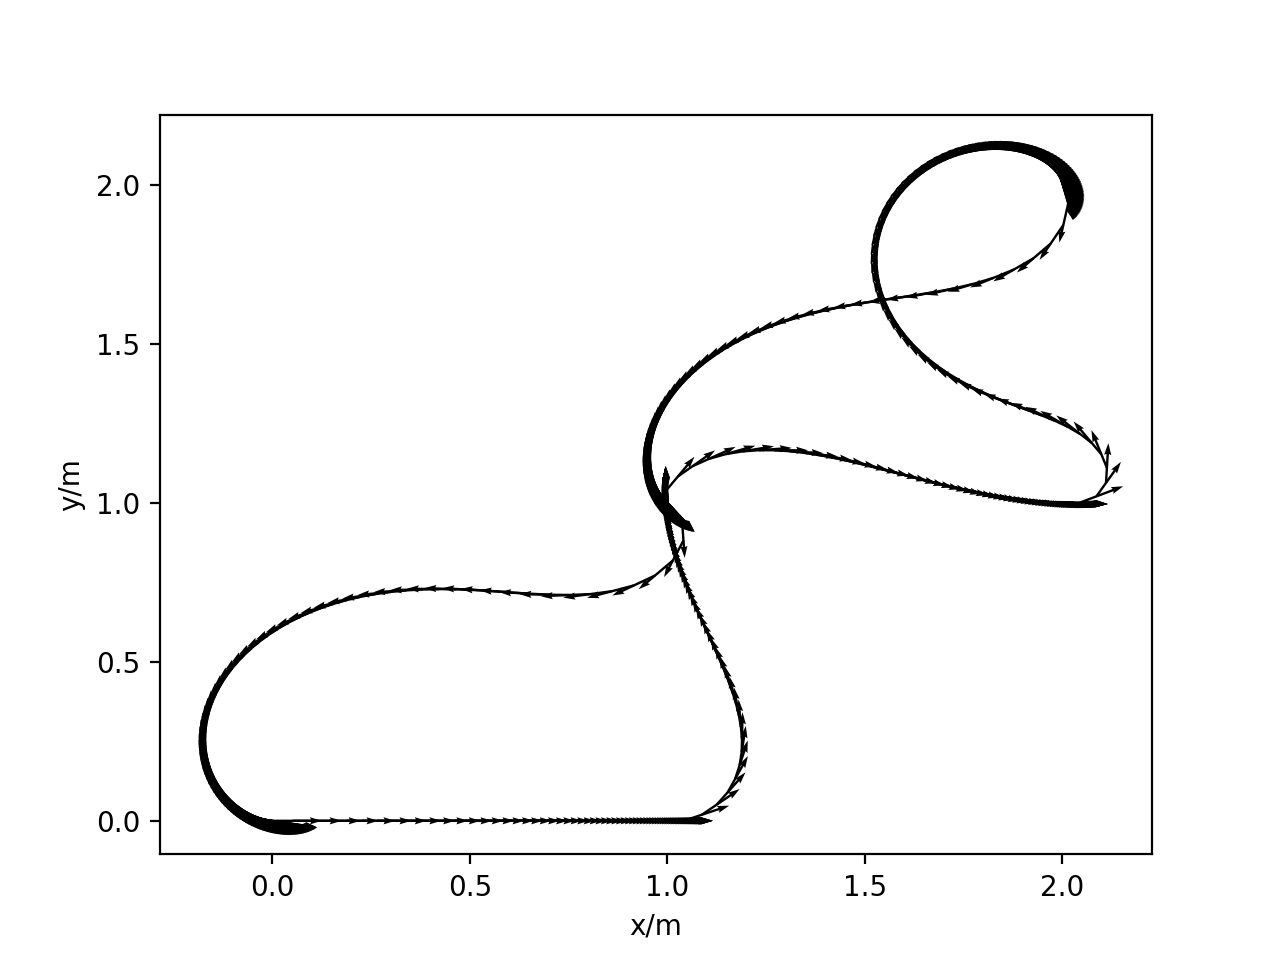

In [16]:
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()

ax.quiver(ptdata[:,0],ptdata[:,1],np.cos(ptdata[:,2]),np.sin(ptdata[:,2]),
          angles='xy', scale_units='xy', scale=8)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
# fig.savefig('ideal_traj.pdf', bbox_inches='tight')


<IPython.core.display.Javascript object>


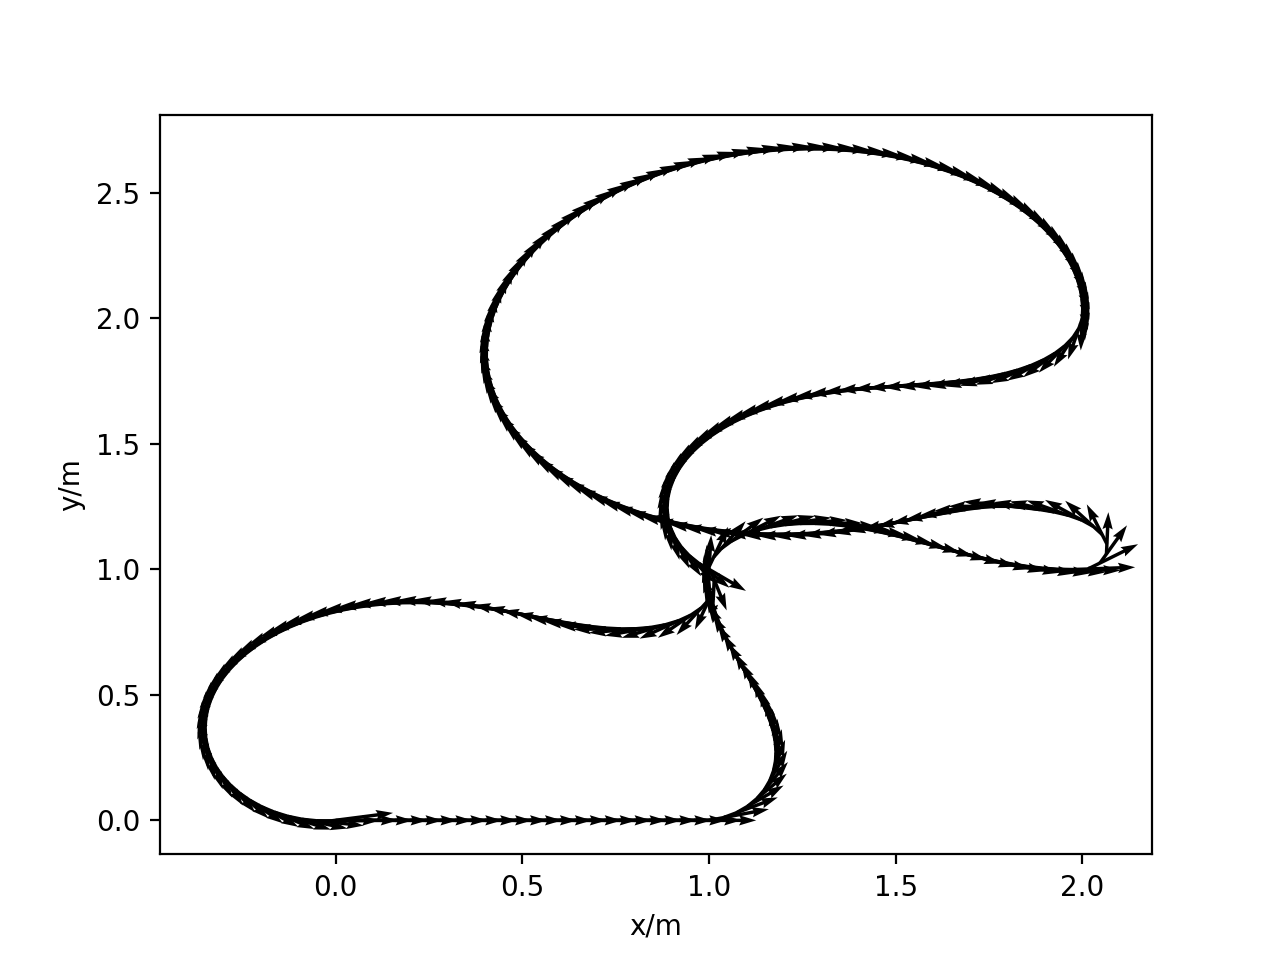

In [314]:
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()

ax.quiver(ptdata[:,0],ptdata[:,1],np.cos(ptdata[:,2]),np.sin(ptdata[:,2]),
          angles='xy', scale_units='xy', scale=6)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')

In [186]:
current_position_pose=(1.0015353862077216, 0.034564115316776375, 0.6442831539208154)
waypoint=(1.0, 1.0, 1.57)
v,gamma=controller(current_position_pose,waypoint,L)

-0.482718552794 -8.67292878925 -1.19239714814


In [142]:
2.1771657143460033*180/pi

124.74240673261097

In [158]:
(0.9939866666666677-1)

-0.006013333333332316

In [ ]:
def isclose(a, b, rel_tol=5e-01, abs_tol=0.1):
    x,y,_=a
    xg,yg,_=b
    deltad=sqrt((xg-x)**2+(yg-x)**2)
    return abs(deltad-0) <= max(rel_tol * max(abs(deltad), abs(0)), abs_tol)

In [180]:
isclose(current_position_pose,waypoint)

True

In [165]:
current_position_pose

(0.9939866666666677, 0.0, 0.0)

In [166]:
waypoint

(1.0, 0.0, 0.0)

In [167]:
x,y,_=current_position_pose

In [168]:
xg,yg,_=waypoint

In [169]:
deltad=sqrt((xg-x)**2+(yg-x)**2)

In [170]:
deltad

0.994004855968466

In [171]:
x

0.9939866666666677

In [172]:
y

0.0

In [173]:
xg

1.0

In [174]:
yg

0.0

In [175]:
(xg-x)**2

3.616017777776554e-05

In [133]:
fw.turn(90+8)

In [123]:
1.0/180*pi

0.017453292519943295

In [262]:
0.759732077139/pi*180


43.5294415807722